In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

In [15]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)
print(parent_dir)
interpolated_dir = os.path.join(parent_dir, "dataset_interpolated_with_overtime")
features = ["score_difference", "type.id", "relative_strength", "home_has_possession", "end.down", "end.yardsToEndzone", "end.distance", "field_position_shift", "home_timeouts_left", "away_timeouts_left"]

/Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/evalRTPF/R/NFL/ML


In [34]:
# Reset the modules
modules_to_reload = [
    'process_data',
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]

import process_data
training_data = process_data.load_data(interpolated_dir, 
                                       years = [2016, 2017,2018, 2019, 2020, 2021, 2022], 
                                       history_length = 0, 
                                       features = features, 
                                       label_feature = "home_win")

test_data = process_data.load_data(interpolated_dir, 
                                       years = [2023, 2024],
                                       history_length = 0, 
                                       features = features, 
                                       label_feature = "home_win")

Loading data for 2022
Loading data for 2024
skipping  2024
Loading data for 2023
skipping  2023
Loading data for 2015
skipping  2015
Loading data for .DS_Store
Loading data for 2017
  NaN found in file: /Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/evalRTPF/R/NFL/ML/dataset_interpolated_with_overtime/2017/game_400951752.csv
[ 0.     0.     0.739  0.     1.    51.    10.     7.     2.     3.   ]
  NaN found in file: /Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/evalRTPF/R/NFL/ML/dataset_interpolated_with_overtime/2017/game_400951752.csv
[ 0.     0.     0.739  0.     1.    51.    10.     7.     2.     3.   ]
  NaN Label found in file: /Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/evalRTPF/R/NFL/ML/dataset_interpolated_with_overtime/2017/game_400951632.csv
  NaN Label found in file: /Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/evalRTPF/R/NFL/ML/dataset_interpolated_with_overtime/2017/game_4009

In [75]:
# Get information about the data
for timestep in training_data:
    print(f"timestep: {timestep}, number of instances: {len(training_data[timestep])}")

timestep: 0.0, number of instances: 2027
timestep: 0.005, number of instances: 1505
timestep: 0.01, number of instances: 1361
timestep: 0.015, number of instances: 1494
timestep: 0.02, number of instances: 1407
timestep: 0.025, number of instances: 1522
timestep: 0.03, number of instances: 1493
timestep: 0.035, number of instances: 1508
timestep: 0.04, number of instances: 1523
timestep: 0.045, number of instances: 1501
timestep: 0.05, number of instances: 1522
timestep: 0.055, number of instances: 1545
timestep: 0.06, number of instances: 1539
timestep: 0.065, number of instances: 1568
timestep: 0.07, number of instances: 1549
timestep: 0.075, number of instances: 1586
timestep: 0.08, number of instances: 1579
timestep: 0.085, number of instances: 1533
timestep: 0.09, number of instances: 1590
timestep: 0.095, number of instances: 1585
timestep: 0.1, number of instances: 1612
timestep: 0.105, number of instances: 1563
timestep: 0.11, number of instances: 1600
timestep: 0.115, number o

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
# Define which features to scale vs. passthrough
numeric_features = [
    "homeScore", "awayScore", "start.down", "start.distance", "start.yardLine",
    "end.down", "end.distance", "end.yardLine",
]
other_features = ["relative_strength", "scoringPlay", "home_has_possession", "home_timeouts_left", "away_timeouts_left"] # for timestep in training_data.keys():


numeric_feature_indices = [
    0,  # score_difference
    1,  # relative_strength  
    4,  # end.down
    5,  # end.yardsToEndzone
    6,  # end.distance
    7,  # field_position_shift
]

# Features that should NOT be scaled (categorical/binary/discrete)
other_feature_indices = [
    2,  # type.id (categorical)
    3,  # home_has_possession (binary)
    8,  # home_timeouts_left (discrete 0-3)
    9,  # away_timeouts_left (discrete 0-3)
]

print("Features to be scaled:", numeric_features)
print("Features to passthrough:", other_features)

# Scale the data pipeline (using column indices for numpy arrays)
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_feature_indices),
    ("passthrough", "passthrough", other_feature_indices)
])

# No scaling pipeline (for comparison)
preprocessor_no_scaling = ColumnTransformer(transformers=[
    ("passthrough", "passthrough", list(range(len(features))))
])
# TO DO:
# - Rounding for end games
# - Only keep home_has_possession + timeouts_left + everything I had before - DONE
# - Kernel based methods
#   - At least 10 data points to do an estimation
#   - Score difference - make it categorical

Features to be scaled: ['homeScore', 'awayScore', 'start.down', 'start.distance', 'start.yardLine', 'end.down', 'end.distance', 'end.yardLine']
Features to passthrough: ['relative_strength', 'scoringPlay', 'home_has_possession', 'home_timeouts_left', 'away_timeouts_left']


In [36]:
# Setup model for each timestep
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


def create_model():
    return Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", LogisticRegression(max_iter=2000))
    ])
# create an array of logistic regression models


models = {}
def setup_models(training_data, test_data):
    for timestep in training_data:
        print(f"Processing timestep: {timestep}")
        X = training_data[timestep]
        y = np.array([row["label"] for row in X])
        # Check for NaN in y
        if np.isnan(y).any():
            print(f"NaN found in y for timestep: {timestep}")
            continue
        X = np.array([row["rows"].reshape(-1) for row in X])
        model = create_model()
        model.fit(X, y)
         # Calculate training loss
        y_pred = model.predict_proba(X)[:, 1]  # Get probability predictions
        train_loss = -np.mean(y * np.log(y_pred + 1e-15) + (1-y) * np.log(1-y_pred + 1e-15))  # Binary cross entropy
        train_accuracy = model.score(X, y)

        y_test = np.array([row["label"] for row in test_data[timestep]])
        X_test = np.array([row["rows"].reshape(-1) for row in test_data[timestep]])
        y_test_pred = model.predict_proba(X_test)[:, 1]
        test_loss = -np.mean(y_test * np.log(y_test_pred + 1e-15) + (1-y_test) * np.log(1-y_test_pred + 1e-15))  # Binary cross entropy 
        test_accuracy = model.score(X_test, y_test)

        print(f"Timestep {timestep:.2%}: Training Loss = {train_loss:.4f}, Accuracy = {train_accuracy:.4f}, Test Loss = {test_loss:.4f}, Test Accuracy = {test_accuracy:.4f}")
        models[timestep] = model


setup_models(training_data, test_data)


Processing timestep: 0.0
Timestep 0.00%: Training Loss = 0.6237, Accuracy = 0.6442, Test Loss = 0.6300, Test Accuracy = 0.6689
Processing timestep: 0.005
Timestep 0.50%: Training Loss = 0.6234, Accuracy = 0.6473, Test Loss = 0.6373, Test Accuracy = 0.6453
Processing timestep: 0.01
Timestep 1.00%: Training Loss = 0.6236, Accuracy = 0.6433, Test Loss = 0.6433, Test Accuracy = 0.6365
Processing timestep: 0.015
Timestep 1.50%: Training Loss = 0.6211, Accuracy = 0.6498, Test Loss = 0.6391, Test Accuracy = 0.6581
Processing timestep: 0.02
Timestep 2.00%: Training Loss = 0.6208, Accuracy = 0.6486, Test Loss = 0.6343, Test Accuracy = 0.6531
Processing timestep: 0.025
Timestep 2.50%: Training Loss = 0.6245, Accuracy = 0.6430, Test Loss = 0.6320, Test Accuracy = 0.6598
Processing timestep: 0.03
Timestep 3.00%: Training Loss = 0.6165, Accuracy = 0.6535, Test Loss = 0.6344, Test Accuracy = 0.6518
Processing timestep: 0.035
Timestep 3.50%: Training Loss = 0.6216, Accuracy = 0.6472, Test Loss = 0.64

In [10]:
def setup_single_model(training_data, test_data):
    # Flatten all training data into single arrays
    X_train = []
    y_train = []
    timesteps_train = []
    for timestep in training_data:
        for row in training_data[timestep]:
            X_train.append(row["rows"].reshape(-1))
            y_train.append(row["label"])
            timesteps_train.append(timestep)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    timesteps_train = np.array(timesteps_train).reshape(-1, 1)  # Column vector

    # Flatten all test data into single arrays
    X_test = []
    y_test = []
    timesteps_test = []
    for timestep in test_data:
        for row in test_data[timestep]:
            X_test.append(row["rows"].reshape(-1))
            y_test.append(row["label"])
            timesteps_test.append(timestep)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    timesteps_test = np.array(timesteps_test).reshape(-1, 1)

    # # Optionally add timestep as a feature
    # X_train = np.hstack([X_train, timesteps_train])
    # X_test = np.hstack([X_test, timesteps_test])

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    y_train_pred = model.predict_proba(X_train)[:, 1]
    train_loss = -np.mean(y_train * np.log(y_train_pred + 1e-15) + (1 - y_train) * np.log(1 - y_train_pred + 1e-15))
    train_accuracy = model.score(X_train, y_train)

    y_test_pred = model.predict_proba(X_test)[:, 1]
    test_loss = -np.mean(y_test * np.log(y_test_pred + 1e-15) + (1 - y_test) * np.log(1 - y_test_pred + 1e-15))
    test_accuracy = model.score(X_test, y_test)

    print(f"Training Loss = {train_loss:.4f}, Accuracy = {train_accuracy:.4f}, Test Loss = {test_loss:.4f}, Test Accuracy = {test_accuracy:.4f}")

    return model

model = setup_single_model(training_data, test_data)

Training Loss = 0.4622, Accuracy = 0.7729, Test Loss = 0.4720, Test Accuracy = 0.7605


0.0
Timestep 0.00%: Test Accuracy = 0.6745
0.005
Timestep 0.50%: Test Accuracy = 0.6486
0.01
Timestep 1.00%: Test Accuracy = 0.6383
0.015
Timestep 1.50%: Test Accuracy = 0.6501
0.02
Timestep 2.00%: Test Accuracy = 0.6548
0.025
Timestep 2.50%: Test Accuracy = 0.6566
0.03
Timestep 3.00%: Test Accuracy = 0.6518
0.035
Timestep 3.50%: Test Accuracy = 0.6571
0.04
Timestep 4.00%: Test Accuracy = 0.6651
0.045
Timestep 4.50%: Test Accuracy = 0.6650
0.05
Timestep 5.00%: Test Accuracy = 0.6749
0.055
Timestep 5.50%: Test Accuracy = 0.6603
0.06
Timestep 6.00%: Test Accuracy = 0.6593
0.065
Timestep 6.50%: Test Accuracy = 0.6529
0.07
Timestep 7.00%: Test Accuracy = 0.6520
0.075
Timestep 7.50%: Test Accuracy = 0.6555
0.08
Timestep 8.00%: Test Accuracy = 0.6483
0.085
Timestep 8.50%: Test Accuracy = 0.6760
0.09
Timestep 9.00%: Test Accuracy = 0.6239
0.095
Timestep 9.50%: Test Accuracy = 0.6517
0.1
Timestep 10.00%: Test Accuracy = 0.6511
0.105
Timestep 10.50%: Test Accuracy = 0.6343
0.11
Timestep 11.00%:

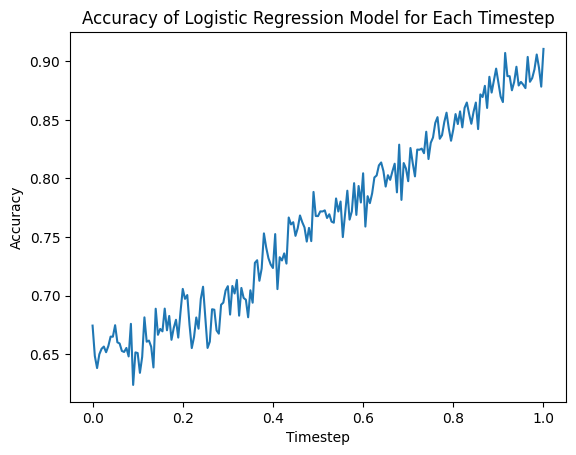

In [37]:
# Test accuracy of model for each timestep on test data and plot
accuracies = []
timesteps = []

for timestep in test_data.keys():
    print(timestep)
    model = models[timestep]
    # Convert test data to array
    y_test = np.array([row["label"] for row in test_data[timestep]])
    X_test = np.array([row["rows"].reshape(-1) for row in test_data[timestep]])
    # Evaluate model using the pipeline (preprocessing + logistic regression)
    test_accuracy = model.score(X_test, y_test)
    print(f"Timestep {timestep:.2%}: Test Accuracy = {test_accuracy:.4f}")
    accuracies.append(test_accuracy)
    timesteps.append(timestep)

plt.plot(timesteps, accuracies)
plt.xlabel("Timestep")
plt.ylabel("Accuracy")
plt.title("Accuracy of Logistic Regression Model for Each Timestep")
plt.show()

In [101]:
# Save the model
import pickle
filename = 'logistic_regression_model.pickle'
pickle.dump(models, open(filename, 'wb'))

In [38]:
# Write the predictions to csv file
# CHANGE CSV COLUMN NAME
for folder in features_test_data:
    print(folder)
    test_data = features_test_data[folder]
    
    for file in test_data:
        df_path = os.path.join(interpolated_dir, folder, file)
        df = pd.read_csv(df_path)
        print(file)

        rows = df.iloc[1:].iterrows()
        try:
            index, row = next(rows)
        except StopIteration:
            continue

        for i, timestep in zip(range(len(models)), models):
            model = models[timestep]
            
            # Get test features for this timestep (skip label)
            feature_vector = np.array(test_data[file][i])[1:]
            
            # Replace NaN values with 0
            feature_vector = np.nan_to_num(feature_vector, nan=0.0)
            
            # Convert to DataFrame with proper column names
            X_test = pd.DataFrame([feature_vector], columns=features[1:])

            # Predict probability using the pipeline
            pred = model.predict_proba(X_test)
            
            # Add prediction to DataFrame for matching timesteps
            try:
                while round(row["timestep"], 3) == round(timestep, 3):
                    df.at[index, "phat_b_LR_2"] = pred[0][1]
                    index, row = next(rows)
            except StopIteration:
                break

        # Save updated file
        df.to_csv(df_path, index=False)
        print(f"Finished writing to {file}")

Loading data for 2024
Processed file:  game_401671629.csv
Processed file:  game_401671601.csv
Processed file:  game_401671826.csv
Processed file:  game_401671832.csv
Processed file:  game_401671749.csv
Processed file:  game_401671775.csv
Processed file:  game_401671761.csv
Processed file:  game_401671760.csv
Processed file:  game_401671774.csv
Processed file:  game_401671748.csv
Processed file:  game_401671833.csv
Processed file:  game_401671827.csv
Processed file:  game_401671600.csv
Processed file:  game_401671628.csv
Processed file:  game_401671616.csv
Processed file:  game_401671831.csv
Processed file:  game_401671825.csv
Processed file:  game_401671819.csv
Processed file:  game_401671762.csv
Processed file:  game_401671776.csv
Processed file:  game_401671789.csv
Processed file:  game_401671788.csv
Processed file:  game_401671777.csv
Processed file:  game_401671763.csv
Processed file:  game_401671818.csv
Processed file:  game_401671824.csv
Processed file:  game_401671830.csv
Proces

In [ ]:
# Debug: Check for NaN values in training and test data
print("=== Checking for NaN values ===")

# Check training data
print("\nTraining data NaN check:")
nan_found_training = False
for timestep in training_data:
    X = training_data[timestep]
    X_array = np.array([row["rows"].reshape(-1) for row in X])
    if np.isnan(X_array).any():
        nan_count = np.isnan(X_array).sum()
        print(f"  Timestep {timestep}: {nan_count} NaN values found")
        nan_found_training = True

if not nan_found_training:
    print("  No NaN values found in training data")

# Check test data
print("\nTest data NaN check:")
nan_found_test = False
for timestep in X_tests:
    X_test_array = np.array(X_tests[timestep])
    if np.isnan(X_test_array).any():
        nan_count = np.isnan(X_test_array).sum()
        print(f"  Timestep {timestep}: {nan_count} NaN values found")
        nan_found_test = True

if not nan_found_test:
    print("  No NaN values found in test data")

print("\n=== NaN check complete ===")


# For Debugging Purposes

In [120]:
for folder in os.listdir(interpolated_dir):
    if not os.path.isdir(os.path.join(interpolated_dir, folder)):
        continue
    print(folder)
    for file in os.listdir(os.path.join(interpolated_dir, folder)):
        if file.endswith(".csv"):
            data = pd.read_csv(os.path.join(interpolated_dir, folder, file))
            # check if data.iloc[1]["homeScore"] is NaN
            if pd.isna(data.iloc[1]["homeScore"]) or pd.isna(data.iloc[1]["awayScore"]):
                print(file)

2022
2023
2019
2021
2020
2018
